<a href="https://colab.research.google.com/github/present42/PyTorchPractice/blob/main/Following_Jax_tutorial_(8)_Stateful_Computations_in_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivation

Some JAX transformation (notably `jax.jit`) impose constraints on teh functionst they transform.

In [1]:
import jax
import jax.numpy as jnp

class Counter:
  def __init__(self):
    self.n = 0

  def count(self) -> int:
    self.n += 1
    return self.n

  def reset(self):
    self.n = 0

counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


`n` attribute maintains the counter's state between successive calls of `count`. It is modified as a side effect of calling `count`.

In [2]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


## The solution: explicit state

Part of the problem with our counter was that the returned value didn't depend on the arguments. Well, why don't we make the state into an argument?

In [3]:
CounterState = int

class CounterV2:
  def count(self, n: CounterState) -> tuple[int, CounterState]:
    # output and counter state (for didactic purpose)
    return n+1, n+1
  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


In [4]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


## Simple worked example: Linear Regression

In [5]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray

def init(rng) -> Params:
  weight_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weight_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)

def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)

LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  grad = jax.grad(loss)(params, x, y)

  new_params = jax.tree_map(lambda param, g: param - LEARNING_RATE * g, params, grad)
  return new_params

Note that we **manually** pipe the params in and out of the update function.

<ipython-input-5-156d8c1a83fb>:23: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  new_params = jax.tree_map(lambda param, g: param - LEARNING_RATE * g, params, grad)


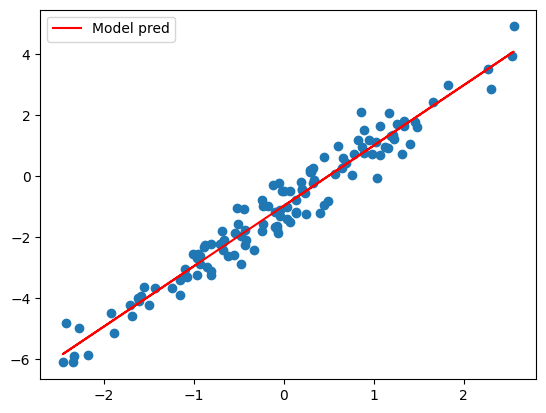

In [6]:
import matplotlib.pyplot as plt

rng = jax.random.key(42)

true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model pred')
plt.legend();